In [1]:
# Force Fresh Files (IF Any Of The Parameters Below Change You Have To Force Fresh Downloads)
force_fresh_download = True

# FourSquare Explore Attributes
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
max_radius = 500 # define radius

# Model Attributes
num_top_venues = 10
min_clusters = 2
max_clusters = 10

In [2]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [3]:
# library for data analysis
import pandas as pd 
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import math

import sys
from ipykernel import kernelapp as app

# library to handle requests
import requests 

# Save Codes Dataframe into a CSV file for debugging 
from project_lib import Project

# library to handle data in a vectorized manner
import numpy as np 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt

# map rendering library
import folium 

print('Libraries imported.')

Libraries imported.


In [4]:
# The code was removed by Watson Studio for sharing.

In [5]:
# Data Assets 
toronto_covid_file = 'toronto_covid.csv'
toronto_population_file = 'toronto_population.csv'
toronto_geolocation_file = 'toronto_geolocation.csv'
toronto_venues_file = 'toronto_venues_file.csv'
foursquare_categories_file = 'foursquare_categories.csv'

# Prepare the project context 
project = Project(project_id=project_id, project_access_token=project_token)
pc = project.project_context

In [6]:
# Function: Check if the CSV file (data asset) is downloaded in the project
def asset_exists(asset_name, asset_type='data_asset'):
    assets = project.get_assets()
    df = pd.DataFrame(assets)
    df = df [df['type'] == asset_type]
    df = df[df['name'].isin([asset_name])]
    return len(df.index)>0

In [7]:
# Download Foursquare Lookup Categories to diustinguish food and beverage venues only
file  = project.get_file(foursquare_categories_file)
cat_lookup_df = pd.read_csv(file, encoding='latin1')

In [8]:
cat_lookup_df.head()

,category,Is Food Or Bev?
0,ATM,n
1,Abruzzo Restaurant,y
2,Acai House,y
3,Accessories Store,n
4,Acehnese Restaurant,y


## Part1: Collecting Data

- Toronto Covis19 reported cases by neighborhood https://open.toronto.ca/dataset/covid-19-cases-in-toronto/
    - Data will be used to compute the total number of confirmed Covid19 Cases per each neighborhood.

In [9]:
# Download Covid Profiles form the Canada Open Data Portal 
if (not asset_exists(toronto_covid_file) or force_fresh_download):
    toronto_covid_df = pd.read_csv('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/e5bf35bc-e681-43da-b2ce-0242d00922ad?format=csv')
    # Save File
    project.save_data(data=toronto_covid_df.to_csv(index=False),file_name=toronto_covid_file,overwrite=True)
    print('{}: File Downloaded'.format(toronto_covid_file))
else:
    print('{}: File Exists'.format(toronto_covid_file))

toronto_covid.csv: File Downloaded


- Toronto neighborhoods population information https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods
    - Source from Canadian Gov 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/File.cfm?T=1201&SR=1&RPP=9999&PR=0&CMA=0&CSD=0&S=22&O=A&Lang=Eng&OFT=CSV'
    - Data will be used to compute the per-capita infection rate (as a reflector of the severity)

In [10]:
# Download Toronto Neighborhood population Data
if (not asset_exists(toronto_population_file) or force_fresh_download):
    toronto_population_df = pd.read_csv('https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/File.cfm?T=1201&SR=1&RPP=9999&PR=0&CMA=0&CSD=0&S=22&O=A&Lang=Eng&OFT=CSV', encoding='latin1')
    print('{}: File Downloaded'.format(toronto_population_file))
    # Save File
    project.save_data(data=toronto_population_df.to_csv(index=False),file_name=toronto_population_file,overwrite=True)
else:
    print('{}: File Exists'.format(toronto_population_file))

toronto_population.csv: File Downloaded


- Toronto Postal Codes Geolocation Data http://cocl.us/Geospatial_data
    - Data will be used to complement the neighborhood information and facilitate the use of Foursquare APIs.

In [11]:
# Download Toronto Geolocation Data
if (not asset_exists(toronto_geolocation_file) or force_fresh_download):
    toronto_geolocation_df = pd.read_csv('http://cocl.us/Geospatial_data')
    print('{}: File Downloaded'.format(toronto_geolocation_file))
    # Save File
    project.save_data(data=toronto_geolocation_df.to_csv(index=False),file_name=toronto_geolocation_file,overwrite=True)
else:
    print('{}: File Exists'.format(toronto_geolocation_file))

toronto_geolocation.csv: File Downloaded


## Part2: Preparing Data 

In [12]:
# Load data file
file  = project.get_file(toronto_covid_file)
toronto_covid_df = pd.read_csv(file)

In [13]:
toronto_covid_df.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,484597,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,484598,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,484599,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,484600,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,484601,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No


In [14]:
toronto_covid_df.shape

(42312, 18)

- Statistically 8 out 10 Covid 19 patients are adults abouve 65 years old 
    - https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/older-adults.html#:~:text=Help%20at%20Home-,The%20risk%20for%20severe%20illness%20with%20COVID%2D19%20increases%20with,than%20people%20in%20their%2050s.
- The data in the data frame is divided by age group with 10 years intervals, between "19 and younger" to "90 and older"
- Typically demorgaphics are devided on three age levels: 
    - children and young adolescents (under 15 years old) [considering 19 and younger due to demogrpahic constraint in the data set]
    - the working-age population (15-64 years) and. [considering 20 to 59 due to demogrpahic constraint in the data set]
    - the elderly population (65 years and older) [considering 60 and older due to demogrpahic constraint in the data set]
- To better target the messages on the education materials on the display boards, cases data is aggregated on three basic risk level
    - children and adolescents: risk level 3.  
    - Working adults: risk Level 2.
    - Elderly: risk Level 1. 
    
    
- For the sake of the analysis we are considering only the age groups per neighborhood. the data set contains additional information including gender, source of infection for instance, which can be further used to disect the population and the provide a more precise targetting, which is outside of the scope of that analysis

In [15]:
# extract the subset cases data frame for our analysis
cases_df = toronto_covid_df[['Age Group','FSA','Classification']]

# exclude the unconfirmed cases 
cases_df = cases_df[cases_df["Classification"] == 'CONFIRMED']

# rename columns 
cases_df.rename(columns={'FSA':'Postal Code'}, inplace=True)

cases_df.shape

(40499, 3)

In [16]:
#rename columns and 
cases_df.head()

,Age Group,Postal Code,Classification
0,50 to 59 Years,M2N,CONFIRMED
1,50 to 59 Years,M2N,CONFIRMED
2,20 to 29 Years,M3A,CONFIRMED
3,60 to 69 Years,M4W,CONFIRMED
4,60 to 69 Years,M4W,CONFIRMED


In [17]:
# Risks Data Frame
risks_df =  pd.DataFrame(data={
  'Age Group': ['19 and younger','20 to 29 Years','30 to 39 Years','40 to 49 Years','50 to 59 Years','60 to 69 Years','70 to 79 Years','80 to 89 Years','90 and older'],
  'Risk Level': ['L3','L2','L2','L2','L2','L1','L1','L1','L1']}).set_index('Age Group')

risks_df.head()

,Risk Level
Age Group,
19 and younger,L3
20 to 29 Years,L2
30 to 39 Years,L2
40 to 49 Years,L2
50 to 59 Years,L2


In [18]:
# Add risks to the Covid Cases Data frame and aggregate Postal Code by the Risk Level
cases_df = cases_df.merge(risks_df, on=['Age Group'])

# drop the Age Group
cases_df = cases_df[['Postal Code','Risk Level']].set_index('Postal Code')

cases_df.head()

,Risk Level
Postal Code,
M2N,L2
M2N,L2
M2R,L2
M2N,L2
M2N,L2


- Aggregate the Total counts by Neighborhood Postal Code

In [19]:
cases_df = cases_df.groupby(['Postal Code','Risk Level']).size().reset_index(name='Cases Count')
cases_df.head()

,Postal Code,Risk Level,Cases Count
0,M1B,L1,302
1,M1B,L2,1010
2,M1B,L3,184
3,M1C,L1,211
4,M1C,L2,317


- Prepare Neighborhood Population Data (To compute Cases Prevalence Per 1000)

In [20]:
# Load data file
file  = project.get_file(toronto_population_file)
population_df = pd.read_csv(file)

In [21]:
population_df.shape

(1649, 7)

In [22]:
population_df.head()

,Geographic code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,01,Canada,NaN,T,35151728.0,15412443.0,14072079.0
1,A0A,A0A,Newfoundland and Labrador,NaN,46587.0,26155.0,19426.0
2,A0B,A0B,Newfoundland and Labrador,NaN,19792.0,13658.0,8792.0
3,A0C,A0C,Newfoundland and Labrador,NaN,12587.0,8010.0,5606.0
4,A0E,A0E,Newfoundland and Labrador,NaN,22294.0,12293.0,9603.0


In [23]:
# extract the subset demographics data frame for our analysis
population_df = population_df[['Geographic code', 'Population, 2016']]

# rename columns 
population_df.rename(columns={'Geographic code':'Postal Code', 'Population, 2016':'Population'}, inplace=True)

# All provinces but the Toronto Neighborhoods 
population_df = population_df[population_df['Postal Code'] != '01']

population_df = population_df.dropna().reset_index()

In [24]:
population_df.head()

,index,Postal Code,Population
0,1,A0A,46587.0
1,2,A0B,19792.0
2,3,A0C,12587.0
3,4,A0E,22294.0
4,5,A0G,35266.0


- The Totals are aggregated by the Postal Code

In [25]:
population_df = population_df.groupby(['Postal Code']).sum().reset_index()

In [26]:
# Merge population with the cases data 
cases_df = cases_df.merge(population_df, on=['Postal Code'])

In [27]:
cases_df.shape

(287, 5)

In [28]:
cases_df.head()

,Postal Code,Risk Level,Cases Count,index,Population
0,M1B,L1,302,895,66108.0
1,M1B,L2,1010,895,66108.0
2,M1B,L3,184,895,66108.0
3,M1C,L1,211,896,35626.0
4,M1C,L2,317,896,35626.0


- Calculate the Previlance of the Covid Cases in Toronto per 1000 / For each Risk Level Group
    - Divide the population size by one thousand. In the example, 250,000 divided by 1,000 equals 250, which is called the quotient, the result of division. Divide the number of occurrences by the previous quotient. In the example, 10,000 divided by 250 equals 40.

In [29]:
cases_df['Per1000'] =  cases_df['Cases Count'] / cases_df['Population'] / 1000

cases_df = cases_df.sort_values(by=['Risk Level','Per1000']).reset_index()

In [30]:
cases_df.head()

,level_0,Postal Code,Risk Level,Cases Count,index,Population,Per1000
0,176,M5J,L1,4,954,14545.0,2.750086e-07
1,165,M5C,L1,1,950,2951.0,3.388682e-07
2,171,M5G,L1,3,952,8423.0,3.561676e-07
3,197,M5V,L1,19,963,49195.0,3.862181e-07
4,138,M4R,L1,6,941,11394.0,5.265929e-07


### Prepare the Geolocation Data

In [31]:
# Load data file
file  = project.get_file(toronto_geolocation_file)
geolocation_df = pd.read_csv(file)

In [32]:
geolocation_df.shape

(103, 3)

In [33]:
geolocation_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [34]:
# Merge population with the cases data 
cases_df = cases_df.merge(geolocation_df, on=['Postal Code'])

In [35]:
cases_df.head()

,level_0,Postal Code,Risk Level,Cases Count,index,Population,Per1000,Latitude,Longitude
0,176,M5J,L1,4,954,14545.0,2.750086e-07,43.640816,-79.381752
1,177,M5J,L2,69,954,14545.0,4.743898e-06,43.640816,-79.381752
2,178,M5J,L3,1,954,14545.0,6.875215e-08,43.640816,-79.381752
3,165,M5C,L1,1,950,2951.0,3.388682e-07,43.651494,-79.375418
4,166,M5C,L2,22,950,2951.0,7.455100e-06,43.651494,-79.375418


- Map Covid19 Cases in Toronto according to the Risk Level and Cases Count Prevelance

In [36]:
# create map of New York using latitude and longitude values
map_canada = folium.Map(location=[geolocation_df['Latitude'][1], geolocation_df['Longitude'][1]], zoom_start=11)

colors_array = ['none','red','orange','yellow'] 

# add markers to map
for lat, lng, postal_code, cases_count, level in zip(cases_df['Latitude'], cases_df['Longitude'], cases_df['Postal Code'], cases_df['Cases Count'], cases_df['Risk Level']):
    label = 'Postal Code:{}|Covid Cases:{}|Risk Level:{}'.format(postal_code, cases_count,level)
    label = folium.Popup(label, parse_html=True)
    l = int(level[1:2])
    r =int(cases_count/l/10)
#     print(r)
    folium.CircleMarker(
        [lat, lng],
        radius=r,
        popup=label,
        color=colors_array[l],
        opacity=0.5,
        fill=True,
        fill_color=colors_array[l],
        fill_opacity=0.5,
        parse_html=False).add_to(map_canada)  
    
map_canada

- The graph shows the three severity levels in concentric circle, red, orange and yellow for Level1 (high risk), level 2 (moderate risk) to level 3 (least risk)

## Part3: Clustring the Postal Code locations in Toronto

- Foursquare API
    - To Lookup and classify top popular venues in each neighborhood as candidates of public ad campaigns.

In [37]:
# Function: extracts the category of the Foursquare venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [38]:
# Function: Extract Near by Venues of the Foursquare Location
def getNearbyVenues(codes, latitudes, longitudes, radius=max_radius):
    venues_list=[]
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])    
    
    if (asset_exists(toronto_venues_file) and not force_fresh_download):   
        file  = project.get_file(toronto_venues_file)
        nearby_venues = pd.read_csv(file)
    else:
        for code, lat, lng in zip(codes, latitudes, longitudes):
            if code not in nearby_venues.values:
                # create the API request URL
                url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, 
                                                                                              CLIENT_SECRET, 
                                                                                              VERSION, 
                                                                                              lat, 
                                                                                              lng, 
                                                                                              radius, 
                                                                                              LIMIT)
                # make the GET request
                results = requests.get(url).json()["response"]['groups'][0]['items']

                # return only relevant information for each nearby venue
                for v in results:
                    v_cat = v['venue']['categories'][0]['name']
                    c = cat_lookup_df.loc[cat_lookup_df['category']==str(v_cat)]
                    #print(c)
                    if (len(c)>0):
                        if (c['Is Food Or Bev?'].tolist()[0]=='y'):
                            venues_list.append([(code, lat, lng, v['venue']['name'],v['venue']['location']['lat'],v['venue']['location']['lng'],v_cat)])
                print('{}\n{}: Venues Downloaded'.format(url,code))
            else:
                print('{}: Venues Exist'.format(code))

            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])    
            nearby_venues.columns = ['Postal Code', 'Latitude', 'Longitude', 
                                     'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

        # Save File
        project.save_data(data=nearby_venues.to_csv(index=False),file_name=toronto_venues_file,overwrite=True)

    print('Fetch Venues Done!')
    return(nearby_venues)

In [39]:
# Function: Sorting Venues in Descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
# The code was removed by Watson Studio for sharing.

- Before proceeding with the clustering we can 

In [41]:
# Flatten the data to generate a single row for each Postal Code and get the total case counts
cases_flat_df = cases_df.groupby(['Postal Code']).sum()

In [42]:
cases_flat_df = cases_flat_df.drop(['Population', 'Latitude','Longitude'], axis=1)
cases_flat_df.head()

,level_0,Cases Count,index,Per1000
Postal Code,,,,
M1B,3,1496,2685,0.000023
M1C,12,589,2688,0.000017
M1E,21,938,2691,0.000020
M1G,30,755,2694,0.000025
M1H,39,438,2697,0.000018


In [43]:
cases_flat_df = cases_flat_df.merge(population_df, on=['Postal Code'])
cases_flat_df = cases_flat_df.merge(geolocation_df, on=['Postal Code'])

In [44]:
cases_flat_df.shape

(96, 9)

In [45]:
cases_flat_df.head()

,Postal Code,level_0,Cases Count,index_x,Per1000,index_y,Population,Latitude,Longitude
0,M1B,3,1496,2685,0.000023,895,66108.0,43.806686,-79.194353
1,M1C,12,589,2688,0.000017,896,35626.0,43.784535,-79.160497
2,M1E,21,938,2691,0.000020,897,46943.0,43.763573,-79.188711
3,M1G,30,755,2694,0.000025,898,29690.0,43.770992,-79.216917
4,M1H,39,438,2697,0.000018,899,24383.0,43.773136,-79.239476


In [46]:
# Collect Toronto's near by venues
toronto_venues = getNearbyVenues(codes=cases_flat_df['Postal Code'],
                                latitudes=cases_flat_df['Latitude'],
                                longitudes=cases_flat_df['Longitude'])


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


https://api.foursquare.com/v2/venues/explore?&client_id=TLRWXS5DLQMLFWGC03IQVK1WDDPYMAJ3WNMMRS4UUETV3JPU&client_secret=V3XW13PUABOZNXARRGANAITPSHTKVRKL0LY2VIRBY5PKCQ1G&v=20180605&ll=43.8066863,-79.19435340000003&radius=500&limit=100
M1B: Venues Downloaded
https://api.foursquare.com/v2/venues/explore?&client_id=TLRWXS5DLQMLFWGC03IQVK1WDDPYMAJ3WNMMRS4UUETV3JPU&client_secret=V3XW13PUABOZNXARRGANAITPSHTKVRKL0LY2VIRBY5PKCQ1G&v=20180605&ll=43.7845351,-79.16049709999999&radius=500&limit=100
M1C: Venues Downloaded
https://api.foursquare.com/v2/venues/explore?&client_id=TLRWXS5DLQMLFWGC03IQVK1WDDPYMAJ3WNMMRS4UUETV3JPU&client_secret=V3XW13PUABOZNXARRGANAITPSHTKVRKL0LY2VIRBY5PKCQ1G&v=20180605&ll=43.7635726,-79.1887115&radius=500&limit=100
M1E: Venues Downloaded
https://api.foursquare.com/v2/venues/explore?&client_id=TLRWXS5DLQMLFWGC03IQVK1WDDPYMAJ3WNMMRS4UUETV3JPU&client_secret=V3XW13PUABOZNXARRGANAITPSHTKVRKL0LY2VIRBY5PKCQ1G&v=20180605&ll=43.7709921,-79.21691740000001&radius=500&limit=100
M1G: V

In [47]:
toronto_venues.shape

(699, 7)

In [48]:
toronto_venues.head()

,Postal Code,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,M1C,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,M1E,43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant
3,M1E,43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
4,M1E,43.763573,-79.188711,Eggsmart,43.767800,-79.190466,Breakfast Spot


- Display the number of Venue Category in each Postal Code

In [49]:
pd.DataFrame(toronto_venues.groupby('Postal Code').count()['Venue Category']).head(10)

,Venue Category
Postal Code,
M1B,1
M1C,1
M1E,3
M1G,1
M1H,4
M1L,2
M1M,1
M1P,4
M1R,2


- And the total number of curated categories

In [50]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 87 uniques categories.


In [51]:
toronto_venues['Venue Category'].unique()

array(['Fast Food Restaurant', 'Bar', 'Restaurant', 'Mexican Restaurant',
       'Breakfast Spot', 'Hakka Restaurant', 'Caribbean Restaurant',
       'Thai Restaurant', 'Bakery', 'American Restaurant',
       'Chinese Restaurant', 'Indian Restaurant', 'Vietnamese Restaurant',
       'Middle Eastern Restaurant', 'Latin American Restaurant',
       'Italian Restaurant', 'Pizza Place', 'Grocery Store',
       'Mediterranean Restaurant', 'Salon / Barbershop', 'Juice Bar',
       'Burger Joint', 'Liquor Store', 'Food Court',
       'Japanese Restaurant', 'Asian Restaurant', 'Burrito Place',
       'Greek Restaurant', 'Ramen Restaurant', 'Sushi Restaurant',
       'Bubble Tea Shop', 'Butcher', 'Food & Drink Shop', 'Beer Store',
       'Dim Sum Restaurant', 'Deli / Bodega', 'Food Truck',
       'Portuguese Restaurant', 'French Restaurant', 'Gastropub',
       'Health Food Store', 'Pub', 'Sports Bar', 'Fish & Chips Shop',
       'Bagel Shop', 'Gay Bar', 'Seafood Restaurant',
       'Comfort Fo

- Analyze Each Postal Code Categories To Narrow down to top 10 Categories in each Postal Code

In [52]:
# one hot encoding
codes_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add Postal Code column back to dataframe
codes_onehot['Postal Code'] = toronto_venues['Postal Code'] 

# move Postal Code column to the first column
fixed_columns = [codes_onehot.columns[-1]] + list(codes_onehot.columns[:-1])
codes_onehot = codes_onehot[fixed_columns]

codes_onehot.head()

,Postal Code,Afghan Restaurant,Airport Food Court,Airport Lounge,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Gaming Cafe,Gastropub,Gay Bar,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grocery Store,Hakka Restaurant,Health Food Store,Hookah Bar,Hotel Bar,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Liquor Store,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Nightclub,Organic Grocery,Pizza Place,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Sake Bar,Salon / Barbershop,Seafood Restaurant,Southern / Soul Food Restaurant,Sports Bar,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,M1B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,M1C,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M1E,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,M1E,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,M1E,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
codes_onehot.shape

(699, 88)

- Grouping by Postal Code and taking the mean of the frequency of occurrence of each category

In [54]:
codes_grouped = codes_onehot.groupby('Postal Code').mean().reset_index()
codes_grouped.head()

,Postal Code,Afghan Restaurant,Airport Food Court,Airport Lounge,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Gaming Cafe,Gastropub,Gay Bar,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grocery Store,Hakka Restaurant,Health Food Store,Hookah Bar,Hotel Bar,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Liquor Store,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Nightclub,Organic Grocery,Pizza Place,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Sake Bar,Salon / Barbershop,Seafood Restaurant,Southern / Soul Food Restaurant,Sports Bar,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0


In [55]:
codes_grouped.shape

(75, 88)

- Displaying the top 10 Venues In each Postal Code according to the Top Categoies

In [56]:
for code in codes_grouped['Postal Code']:
    print("----"+code+"----")
    temp = codes_grouped[codes_grouped['Postal Code'] == code].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M1B----
                       venue  freq
0       Fast Food Restaurant   1.0
1          Afghan Restaurant   0.0
2        Japanese Restaurant   0.0
3  Middle Eastern Restaurant   0.0
4         Mexican Restaurant   0.0
5   Mediterranean Restaurant   0.0
6           Malay Restaurant   0.0
7               Liquor Store   0.0
8  Latin American Restaurant   0.0
9          Korean Restaurant   0.0


----M1C----
                       venue  freq
0                        Bar   1.0
1          Afghan Restaurant   0.0
2        Japanese Restaurant   0.0
3  Middle Eastern Restaurant   0.0
4         Mexican Restaurant   0.0
5   Mediterranean Restaurant   0.0
6           Malay Restaurant   0.0
7               Liquor Store   0.0
8  Latin American Restaurant   0.0
9          Korean Restaurant   0.0


----M1E----
                       venue  freq
0         Mexican Restaurant  0.33
1                 Restaurant  0.33
2             Breakfast Spot  0.33
3          Afghan Restaurant  0.00
4              

In [57]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [58]:
# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Postal Code'] = codes_grouped['Postal Code']

for ind in np.arange(codes_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(codes_grouped.iloc[ind, :], num_top_venues)

In [59]:
toronto_venues_sorted.shape

(75, 11)

In [60]:
toronto_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Fast Food Restaurant,Wine Bar,Eastern European Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Doner Restaurant,Donut Shop
1,M1C,Bar,Wine Bar,Eastern European Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Doner Restaurant,Donut Shop
2,M1E,Mexican Restaurant,Breakfast Spot,Restaurant,Donut Shop,Cocktail Bar,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant
3,M1G,Mexican Restaurant,Wine Bar,Gastropub,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Doner Restaurant,Donut Shop
4,M1H,Caribbean Restaurant,Thai Restaurant,Hakka Restaurant,Bakery,Eastern European Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant


## Clustring the Cases, Venues, Codes Data

In [61]:
# Data Frame to use in training and clusering 
codes_grouped_clustering = codes_grouped.drop('Postal Code', 1)

In [62]:
codes_grouped_clustering.head()

,Afghan Restaurant,Airport Food Court,Airport Lounge,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Gaming Cafe,Gastropub,Gay Bar,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grocery Store,Hakka Restaurant,Health Food Store,Hookah Bar,Hotel Bar,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Liquor Store,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Nightclub,Organic Grocery,Pizza Place,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Sake Bar,Salon / Barbershop,Seafood Restaurant,Southern / Soul Food Restaurant,Sports Bar,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0


In [63]:
# Using Elbow method to determine the optimum number of clusters
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(min_clusters, max_clusters) 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(codes_grouped_clustering) 
    kmeanModel.fit(codes_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(codes_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / codes_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(codes_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / codes_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

In [64]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

2 : 0.514345347608573
3 : 0.4865291154241753
4 : 0.4543325265790288
5 : 0.45579764875637513
6 : 0.43396935021393007
7 : 0.4220057861000143
8 : 0.40142215335363335
9 : 0.39406958292694766


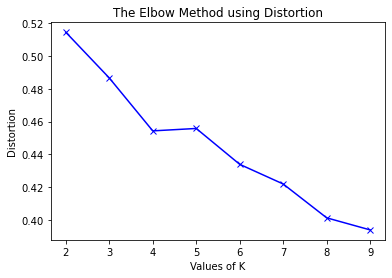

In [65]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [66]:
# Using the different values for Inetia
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

2 : 25.340513862294262
3 : 23.021329426872036
4 : 21.29640357147252
5 : 19.962093322719035
6 : 18.64604227739015
7 : 17.4956722857955
8 : 16.396790094323716
9 : 15.413256104090145


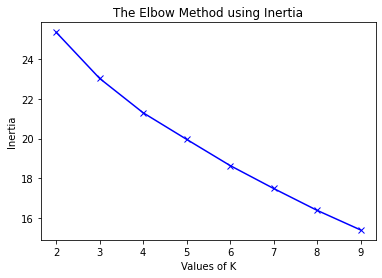

In [67]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

### Elbow Method is not conclusive of the optimal number of Clusters to use 

- Reverting to selecting the number of clusters with silhouette analysis

For n_clusters = 2, silhouette score is 0.2928217281949424)
For n_clusters = 3, silhouette score is 0.14935756312412957)
For n_clusters = 4, silhouette score is 0.24393371026894128)
For n_clusters = 5, silhouette score is 0.21698028069033135)
For n_clusters = 6, silhouette score is 0.20256572533455972)
For n_clusters = 7, silhouette score is 0.22604347618134882)
For n_clusters = 8, silhouette score is 0.261563599499686)
For n_clusters = 9, silhouette score is 0.22880046936198928)


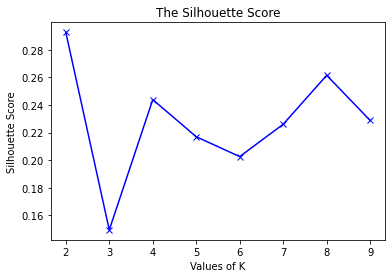

In [68]:
K = range(min_clusters, max_clusters) 
s_scores = [] 

for n_clusters in K:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(codes_grouped_clustering)
    centers = clusterer.cluster_centers_
    score = silhouette_score(codes_grouped_clustering, preds)
    s_scores.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    
plt.plot(K, s_scores, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Score') 
plt.title('The Silhouette Score') 
plt.show() 

In [69]:
# set number of clusters
kclusters = s_scores.index(max(s_scores)) + min_clusters

In [70]:
print('Setting the value of Clusters at the silhouette score method\nClusters: {}'.format(kclusters))

Setting the value of Clusters at the silhouette score method
Clusters: 2


In [71]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(codes_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:num_top_venues] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [72]:
codes_grouped_clustering.shape

(75, 87)

In [73]:
# add clustering labels
toronto_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

codes_merged = toronto_venues_sorted.set_index('Postal Code')

In [74]:
# merge canada_grouped with df_codes to add latitude/longitude for each neighborhood
codes_merged = codes_merged.join(cases_flat_df.set_index('Postal Code'), on='Postal Code')

In [75]:
codes_merged = codes_merged.dropna(subset=['Cluster Labels'])

In [76]:
codes_merged = codes_merged.reset_index() # check the last columns!

In [77]:
# create map
map_clusters = folium.Map(location=[geolocation_df['Latitude'][1], geolocation_df['Longitude'][1]], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
print(ys)

[array([0, 1]), array([1, 3])]


In [78]:
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
print(colors_array)
rainbow = [colors.rgb2hex(i) for i in colors_array]

[[5.0000000e-01 0.0000000e+00 1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.2246468e-16 6.1232340e-17 1.0000000e+00]]


In [79]:
# add markers to the map
markers_colors = []
for latitude, longitude, code, cluster, cases_count in zip(codes_merged['Latitude'], 
                                                           codes_merged['Longitude'], 
                                                           codes_merged['Postal Code'], 
                                                           codes_merged['Cluster Labels'], 
                                                           codes_merged['Cases Count']):
    label = folium.Popup(str(code) + ' Cluster ' + str(cluster), parse_html=True)
    int_cluster = int(cluster)
    r = int(cases_count/500)
    folium.CircleMarker(
        [latitude, longitude],
        radius= 4,#r,
        popup=label,
        color=rainbow[int_cluster-1],
        fill=True,
        fill_color=rainbow[int_cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

## Part4: Analysis and Discussion

In [122]:
# Function: Plot Categories in each Cluster 
def plot_categories(cluster_df):
    if len(cluster_df)==0:
        return
    vals = cluster_df[['1st Most Common Venue',
                '2nd Most Common Venue',
                '3rd Most Common Venue',
                '4th Most Common Venue',
                '5th Most Common Venue',
                '6th Most Common Venue',
                '7th Most Common Venue',
                '8th Most Common Venue',
                '9th Most Common Venue',
                '10th Most Common Venue'
               ]].values.tolist() 
    categories = []
    for vs in vals:
        for v in vs:
            categories.append(v)
    c_df = pd.DataFrame(data= {'Categories':categories})
    c_df = c_df.groupby(['Categories']).size().reset_index(name='Count').sort_values(by=['Count'])
#     c_df = c_df.head(15)  
    print(c_df)
    c_df.plot.barh(x='Categories', y='Count')

In [123]:
# Function: Plot Categories in each Cluster 
def plot_severities(cluster_df):
    if len(cluster_df)==0:
        return
    print('Total number of Postal Codes in the cluster is:{} (out of {} total)\nTotal number of Covid19 cases of:{} ({}% of all Cases)'.
          format(
              len(cluster_df['Postal Code'].unique()),
              len(cases_df['Postal Code'].unique()),
              sum(cluster_df['Cases Count']),
              math.trunc(sum(100*cluster_df['Cases Count'])/sum(cases_df['Cases Count'])*100)/100))
    pc = cluster_df[['Postal Code']]
    pc = pc.merge(cases_df, on=['Postal Code'])
    grouped_df = pc.groupby(['Risk Level']).sum().reset_index().sort_values(by=['Risk Level'])
    grouped_df = grouped_df.reset_index()
    print(grouped_df['Risk Level','Cases Count','Population','Per1000'])
    grouped_df.plot.barh(x='Risk Level', y='Cases Count', stacked=True)

In [124]:
# Cluster 1
# Display and chart Cluster data
df1 = codes_merged.loc[codes_merged['Cluster Labels'] == 0, codes_merged.columns[[1] + list(range(0, codes_merged.shape[1]))]]
df1.shape

(65, 21)

In [125]:
plot_severities(df1)
plot_categories(df1)

Total number of Postal Codes in the cluster is:65 (out of 96 total)
Total number of Covid19 cases of:26851 (67.45% of all Cases)


ValueError: cannot insert level_0, already exists

In [84]:
# Cluster 2
# Display and chart Cluster data
df2 = codes_merged.loc[codes_merged['Cluster Labels'] == 1, codes_merged.columns[[1] + list(range(0, codes_merged.shape[1]))]]
df2.shape

(10, 21)

Total number of Postal Codes in the cluster is:10 (out of 96 total)
Total number of Covid19 cases of:5807 (14.58% of all Cases)


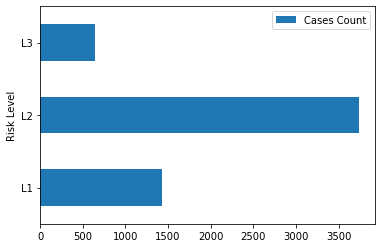

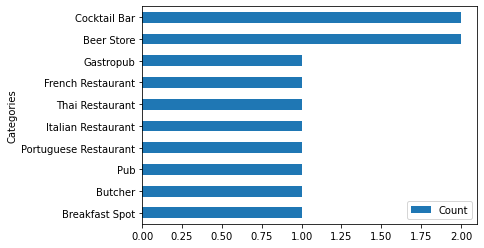

In [85]:
plot_severities(df2)
plot_categories(df2)

In [86]:
# Cluster 3
df3 = codes_merged.loc[codes_merged['Cluster Labels'] == 2, codes_merged.columns[[1] + list(range(0, codes_merged.shape[1]))]]
df3.shape

(0, 21)

In [87]:
plot_severities(df3)
plot_categories(df3)

In [88]:
# Cluster 4
df4 = codes_merged.loc[codes_merged['Cluster Labels'] == 3, codes_merged.columns[[1] + list(range(0, codes_merged.shape[1]))]]
df4.shape

(0, 21)

In [89]:
plot_severities(df4)
plot_categories(df4)

In [90]:
# Cluster 5
df5 = codes_merged.loc[codes_merged['Cluster Labels'] == 4, codes_merged.columns[[1] + list(range(0, codes_merged.shape[1]))]]
df5.shape

(0, 21)

In [91]:
plot_severities(df5)
plot_categories(df5)

In [92]:
# Cluster 6
df6 = codes_merged.loc[codes_merged['Cluster Labels'] == 5, codes_merged.columns[[1] + list(range(0, codes_merged.shape[1]))]]
df6.shape

(0, 21)

In [93]:
plot_severities(df6)
plot_categories(df6)

In [94]:
# Cluster 7
df7 = codes_merged.loc[codes_merged['Cluster Labels'] == 5, codes_merged.columns[[1] + list(range(0, codes_merged.shape[1]))]]
df7.shape

(0, 21)

In [95]:
plot_severities(df7)
plot_categories(df7)

In [96]:
# Cluster 8
df8 = codes_merged.loc[codes_merged['Cluster Labels'] == 7, codes_merged.columns[[1] + list(range(0, codes_merged.shape[1]))]]
df8.shape

(0, 21)

In [97]:
plot_severities(df8)
plot_categories(df8)

In [98]:
# Cluster 9
df9 = codes_merged.loc[codes_merged['Cluster Labels'] == 8, codes_merged.columns[[1] + list(range(0, codes_merged.shape[1]))]]
df9.shape

(0, 21)

In [99]:
plot_severities(df9)
plot_categories(df9)

In [100]:
# Cluster 10
df10 = codes_merged.loc[codes_merged['Cluster Labels'] == 9, codes_merged.columns[[1] + list(range(0, codes_merged.shape[1]))]]
df10.shape

(0, 21)

In [101]:
plot_severities(df10)
plot_categories(df10)